In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/576_Project_Plan/
!ls -la

/content/drive/My Drive/Colab Notebooks/576_Project_Plan
total 8086921
-rw------- 1 root root        151 Apr 26 00:34  576_Project_Results.gsheet
-rw------- 1 root root    9970669 Mar 31 20:13  Assignment3_final-Copy1.ipynb
-rw------- 1 root root     106330 Mar 31 20:13  build_vocab.py
-rw------- 1 root root     328249 Mar 31 12:23 'Copy of read_data_project.ipynb'
-rw------- 1 root root       3324 Mar 31 20:13  DataLoader.ipynb
-rw------- 1 root root       2349 Apr 25 19:00  DataLoader.py
-rw------- 1 root root        151 Mar 31 23:37  DataLoader.py.gdoc
-rw------- 1 root root  196491988 Apr 25 00:31  decoder_gnkdhind_1epoch.pkl
-rw------- 1 root root  195683489 Apr 24 21:12  decoder_nmt_dicts.pkl
-rw------- 1 root root  207911357 Apr 25 21:53  decoder_nmt_gnkdetatoehind_1epochLR01.pkl
-rw------- 1 root root  207911357 Apr 25 21:40  decoder_nmt_gnkdetatoehind.pkl
-rw------- 1 root root  152979594 Apr 26 20:23  decoder_nmt_lstmbidim_gnhind.pkl
-rw------- 1 root root  216833459 Apr 23 0

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow
from torch.autograd import Variable

import time
import io
import os
import pickle
import argparse
from PIL import Image
import numpy as np

from Vocabulary import load_captions
from Vocabulary import Vocabulary
from DataLoader import DataLoader, shuffle_data
%matplotlib inline

In [0]:
#Model 1 (VGG16 as Encoder)
class EncoderCNN(nn.Module):
    def __init__(self, embed_dim):
        """Load the pretrained vgg16 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        in_features = self.vgg16.classifier[6].in_features
        self.linear = nn.Linear(in_features, embed_dim)
        self.vgg16.classifier[6] = self.linear
        self.init_weights()
        
    def init_weights(self):
        self.linear.weight.data.normal_(0.0, 0.02)
        self.linear.bias.data.fill_(0)
    
    def forward(self, images):
        embed = self.vgg16(images)
        return embed

In [0]:
class Resnet(nn.Module):
    def __init__(self, embedding_dim=256):
        super(Resnet, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        in_features = self.resnet18.fc.in_features
        modules = list(self.resnet18.children())[:-1]
        self.resnet18 = nn.Sequential(*modules)
        self.linear = nn.Linear(in_features, embedding_dim)
        # self.batch_norm = nn.BatchNorm1d(embedding_dim, momentum=0.01)
        self.init_weights()
    
    def init_weights(self):
        self.linear.weight.data.normal_(0.0, 0.02)
        self.linear.bias.data.fill_(0)
    
    def forward(self, images):
        embed = self.resnet18(images)
        embed = Variable(embed.data)
        embed = embed.view(embed.size(0), -1)
        embed = self.linear(embed)
        # embed = self.batch_norm(embed)
        return embed

In [0]:
#Model 1 Decoder (Greedy Search)
class DecoderRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(DecoderRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.init_weights()
    
    def init_weights(self):
        self.word_embeddings.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)
        
    def forward(self, features, caption):
        seq_length = len(caption) + 1
        embeds = self.word_embeddings(caption)
        embeds = torch.cat((features, embeds), 0)
        lstm_out, _ = self.lstm(embeds.unsqueeze(1))
        out = self.linear(lstm_out.view(seq_length, -1))
        return out

    def greedy(self, cnn_out, seq_len = 20):
        ip = cnn_out
        hidden = None
        ids_list = []
        for t in range(seq_len):
            lstm_out, hidden = self.lstm(ip.unsqueeze(1), hidden)
            # generating single word at a time
            linear_out = self.linear(lstm_out.squeeze(1))
            word_caption = linear_out.max(dim=1)[1]
            ids_list.append(word_caption)
            ip = self.word_embeddings(word_caption)
        return ids_list
     
    def sample(self, cnn_out, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
# Number of Training Examples
import glob
len(glob.glob('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/train/*'))

6001

In [9]:
#loading vocabulary
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_dir = "/content/drive/My Drive/Colab Notebooks/576_Project_Plan/train"
threshold = 5
captions_dict = load_captions(train_dir)
vocab = Vocabulary(captions_dict, threshold)
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)
print('dictionary dump')


dictionary dump


In [10]:
#Transforming Images and Loading data
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

dataloader = DataLoader(train_dir, vocab, transform)

data = dataloader.gen_data()
print(train_dir + ' loaded')

/content/drive/My Drive/Colab Notebooks/576_Project_Plan/train loaded


In [11]:
#Initializing hyper-parameters
vocab_size = vocab.index
hidden_dim = 512
embedding_dim = 300
learning_rate = 1e-3
cnn = EncoderCNN(embedding_dim)
lstm = DecoderRNN(embedding_dim,hidden_dim,vocab_size = vocab_size)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [12]:
#Utilizing GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
cnn.to(device)
lstm.to(device)

DecoderRNN(
  (word_embeddings): Embedding(2550, 300)
  (lstm): LSTM(300, 512)
  (linear): Linear(in_features=512, out_features=2550, bias=True)
)

In [0]:
#Defining loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(cnn.linear.parameters()) + list(lstm.parameters()) 
optimizer = torch.optim.Adam(params, lr = learning_rate)
num_epochs = 25

In [15]:
#Loading trained model to train further (Comment if running from begining)
cnn.load_state_dict(torch.load("iter_new_21_cnn.pkl"))
lstm.load_state_dict(torch.load("iter_new_21_lstm.pkl"))

<All keys matched successfully>

In [16]:
#Traning the model (Change numbers in range function according to the epoch)

for epoch in range(22, num_epochs+1):
    shuffled_images, shuffled_captions = shuffle_data(data, seed = epoch)
    num_captions = len(shuffled_captions)
    loss_list = []
    tic = time.time()
    for i in range(num_captions):
        image_id = shuffled_images[i]
        image = dataloader.get_image(image_id)
        image = image.unsqueeze(0)
        
        image = Variable(image).cuda()
        caption = torch.cuda.LongTensor(shuffled_captions[i])
        caption_train = caption[:-1] # remove <end>
        cnn.zero_grad()
        lstm.zero_grad()

        cnn_out = cnn(image)
        lstm_out = lstm(cnn_out, caption_train)
        loss = criterion(lstm_out, caption)
        loss.backward()
        optimizer.step()
        loss_list.append(loss)
    toc = time.time()
    avg_loss = torch.mean(torch.Tensor(loss_list))
    print('epoch %d avg_loss %f time %.2f mins' %(epoch, avg_loss, (toc-tic)/60))
    if epoch % 2 == 0:
        torch.save(cnn.state_dict(),'iter_new_%d_cnn.pkl'%(epoch))
        torch.save(lstm.state_dict(),'iter_new_%d_lstm.pkl'%(epoch))

epoch 22 avg_loss 1.984577 time 28.38 mins
epoch 23 avg_loss 1.957615 time 28.37 mins
epoch 24 avg_loss 1.947934 time 28.37 mins
epoch 25 avg_loss 1.942562 time 28.38 mins


In [82]:
#Loading trained model to train further (Comment if running from begining)
cnn.load_state_dict(torch.load("iter_new_24_cnn.pkl"))
lstm.load_state_dict(torch.load("iter_new_24_lstm.pkl"))

<All keys matched successfully>

prediction:   <start> the are in snow brown the pulling play <end>


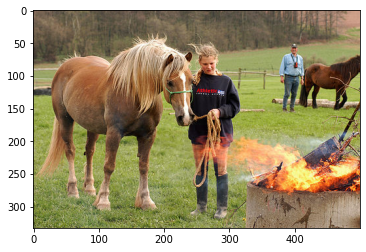

In [85]:
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/train_image_pred/1.jpg', 'r')
# pil_im = Image.open('/home/team8/bhk.jpg', 'r')
test = np.asarray(pil_im)

test = transform(pil_im)
test = test.unsqueeze(0)
test = Variable(test).cuda()

cnn_out = cnn(test)
lstm_out = lstm.greedy(cnn_out)

imshow(np.asarray(pil_im))
print("prediction: ",vocab.get_sentence(lstm_out))

prediction:   <start> the people a the his talk in pink red the shot play <end>


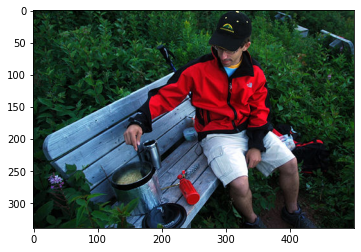

In [86]:
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/train_image_pred/2.jpg', 'r')
# pil_im = Image.open('/home/team8/bhk.jpg', 'r')
test = np.asarray(pil_im)

test = transform(pil_im)
test = test.unsqueeze(0)
test = Variable(test).cuda()

cnn_out = cnn(test)
lstm_out = lstm.greedy(cnn_out)

imshow(np.asarray(pil_im))
print("prediction: ",vocab.get_sentence(lstm_out))

prediction:   <start> the are in snow brown the pulling play <end>


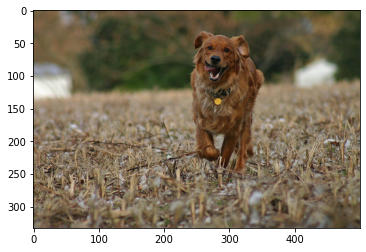

In [87]:
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/train_image_pred/3.jpg', 'r')
# pil_im = Image.open('/home/team8/bhk.jpg', 'r')
test = np.asarray(pil_im)

test = transform(pil_im)
test = test.unsqueeze(0)
test = Variable(test).cuda()

cnn_out = cnn(test)
lstm_out = lstm.greedy(cnn_out)

imshow(np.asarray(pil_im))
print("prediction: ",vocab.get_sentence(lstm_out))

prediction:   <start> the standing in number red the chase onlookers the are play <end>


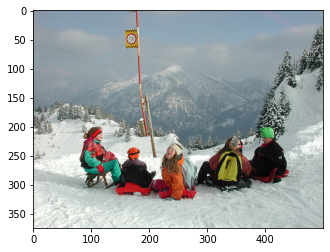

In [88]:
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/train_image_pred/5.jpg', 'r')
# pil_im = Image.open('/home/team8/bhk.jpg', 'r')
test = np.asarray(pil_im)

test = transform(pil_im)
test = test.unsqueeze(0)
test = Variable(test).cuda()

cnn_out = cnn(test)
lstm_out = lstm.greedy(cnn_out)

imshow(np.asarray(pil_im))
print("prediction: ",vocab.get_sentence(lstm_out))

prediction:   <start> the people a the his talk in her a fence small play <end>


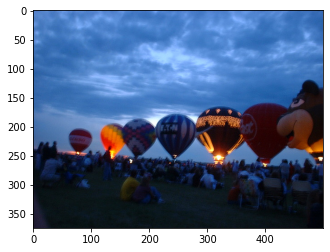

In [90]:
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/train_image_pred/6.jpg', 'r')
# pil_im = Image.open('/home/team8/bhk.jpg', 'r')
test = np.asarray(pil_im)

test = transform(pil_im)
test = test.unsqueeze(0)
test = Variable(test).cuda()

cnn_out = cnn(test)
lstm_out = lstm.greedy(cnn_out)

imshow(np.asarray(pil_im))
print("prediction: ",vocab.get_sentence(lstm_out))

prediction:   <start> the standing a the dogs talk another beach in number red the backyard play <end>


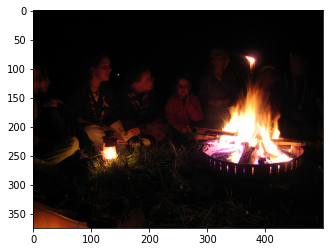

In [91]:
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/train_image_pred/4.jpg', 'r')
# pil_im = Image.open('/home/team8/bhk.jpg', 'r')
test = np.asarray(pil_im)

test = transform(pil_im)
test = test.unsqueeze(0)
test = Variable(test).cuda()

cnn_out = cnn(test)
lstm_out = lstm.greedy(cnn_out)

imshow(np.asarray(pil_im))
print("prediction: ",vocab.get_sentence(lstm_out))

prediction:   <start> the standing in number red the plastic outstretched onlookers the wearing motorbike a fence running four fence small play


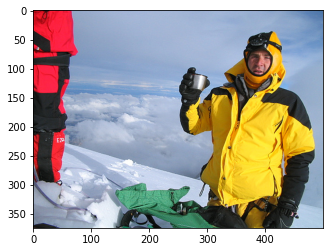

In [95]:
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/train_image_pred/7.jpg', 'r')
# pil_im = Image.open('/home/team8/bhk.jpg', 'r')
test = np.asarray(pil_im)

test = transform(pil_im)
test = test.unsqueeze(0)
test = Variable(test).cuda()

cnn_out = cnn(test)
lstm_out = lstm.greedy(cnn_out)

imshow(np.asarray(pil_im))
print("prediction: ",vocab.get_sentence(lstm_out))

prediction:   <start> the are in snow brown the pulling play <end>


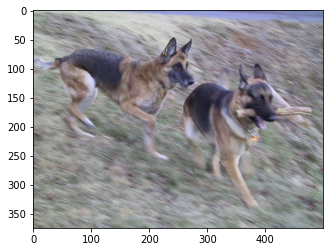

In [96]:
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/train_image_pred/8.jpg', 'r')
# pil_im = Image.open('/home/team8/bhk.jpg', 'r')
test = np.asarray(pil_im)

test = transform(pil_im)
test = test.unsqueeze(0)
test = Variable(test).cuda()

cnn_out = cnn(test)
lstm_out = lstm.greedy(cnn_out)

imshow(np.asarray(pil_im))
print("prediction: ",vocab.get_sentence(lstm_out))

prediction:   <start> the standing a the his court in number red the male play <end>


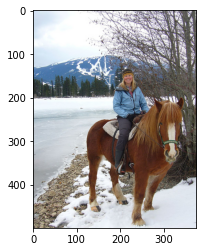

In [99]:
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/train_image_pred/9.jpg', 'r')
# pil_im = Image.open('/home/team8/bhk.jpg', 'r')
test = np.asarray(pil_im)

test = transform(pil_im)
test = test.unsqueeze(0)
test = Variable(test).cuda()

cnn_out = cnn(test)
lstm_out = lstm.greedy(cnn_out)

imshow(np.asarray(pil_im))
print("prediction: ",vocab.get_sentence(lstm_out))

prediction:   <start> the is man a the sit an another yellow clothing soccer in sky red the blond play <end>


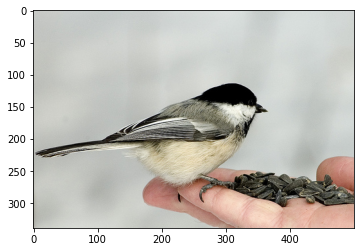

In [100]:
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/train_image_pred/10.jpg', 'r')
# pil_im = Image.open('/home/team8/bhk.jpg', 'r')
test = np.asarray(pil_im)

test = transform(pil_im)
test = test.unsqueeze(0)
test = Variable(test).cuda()

cnn_out = cnn(test)
lstm_out = lstm.greedy(cnn_out)

imshow(np.asarray(pil_im))
print("prediction: ",vocab.get_sentence(lstm_out))

prediction:   <start> the standing a the of talk another yellow beach in number red the backyard play <end>


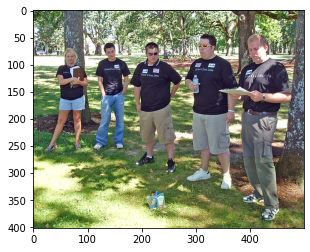

In [110]:
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/train_image_pred/13.jpg', 'r')
# pil_im = Image.open('/home/team8/bhk.jpg', 'r')
test = np.asarray(pil_im)

test = transform(pil_im)
test = test.unsqueeze(0)
test = Variable(test).cuda()

cnn_out = cnn(test)
lstm_out = lstm.greedy(cnn_out)

imshow(np.asarray(pil_im))
print("prediction: ",vocab.get_sentence(lstm_out))

prediction:   <start> the standing in off the grassy runs the chase play <end>


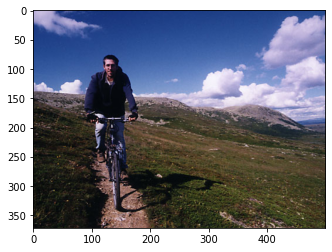

In [113]:
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/train_image_pred/15.jpg', 'r')
# pil_im = Image.open('/home/team8/bhk.jpg', 'r')
test = np.asarray(pil_im)

test = transform(pil_im)
test = test.unsqueeze(0)
test = Variable(test).cuda()

cnn_out = cnn(test)
lstm_out = lstm.greedy(cnn_out)

imshow(np.asarray(pil_im))
print("prediction: ",vocab.get_sentence(lstm_out))

In [0]:
# Bleu score calculation

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

test_dir = "/content/drive/My Drive/Colab Notebooks/576_Project_Plan/test"

threshold = 5
captions_dict = load_captions(test_dir)
vocab = Vocabulary(captions_dict, threshold)

with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

print('dictionary dump')


transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

dataloader_test = DataLoader(test_dir, vocab, transform)

data_test = dataloader_test.gen_data()
print(test_dir + ' loaded')



from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
test_images = list(captions_dict.keys())

ground_truth = []
predicted = []

i = 0
for im in test_images:

    image = dataloader_test.get_image(im)

    image = image.unsqueeze(0)
    image = Variable(image).cuda()

    cnn_out = cnn(image)
    lstm_out = lstm.greedy(cnn_out)

    try:
      vocab.get_sentence(lstm_out)

      if i < 7:
        
        print("prediction: ",vocab.get_sentence(lstm_out))

        i =  i+1

      model_sent = ' '.join(vocab.get_sentence(lstm_out).strip().split(' ')[1:-1]).split()
      
      s1 = captions_dict[im][0].split()
      s2 = captions_dict[im][1].split()
      s3 = captions_dict[im][2].split()
      s4 = captions_dict[im][3].split()
      s5 = captions_dict[im][4].split()
      cap = [s1, s2, s3, s4, s5]

      predicted.append(model_sent)
      ground_truth.append(cap)

    except:
      pass

# print(corpus_bleu(ground_truth, predicted, weights=(1, 0, 0, 0)))
# print(corpus_bleu(ground_truth, predicted, weights=(0.5, 0.5, 0, 0)))
# print(corpus_bleu(ground_truth, predicted, weights=(1.0/3.0, 1.0/3.0, 1.0/3.0, 0)))
# print(corpus_bleu(ground_truth, predicted))


prediction:   <start> the dogs are in snow brown fence performing play <end>


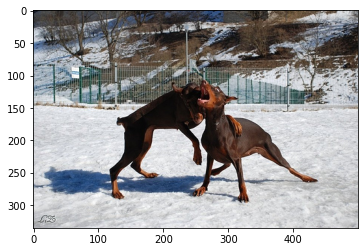

In [119]:
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/test/3385593926_d3e9c21170.jpg', 'r')
# pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/test/2677656448_6b7e7702af.jpg', 'r')
# pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/test/311146855_0b65fdb169.jpg', 'r')
# pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/test/1258913059_07c613f7ff.jpg', 'r')
# pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/test/241347760_d44c8d3a01.jpg', 'r')
# pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/test/2654514044_a70a6e2c21.jpg', 'r')
# pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/test/2339106348_2df90aa6a9.jpg', 'r')

# pil_im = Image.open('/home/team8/bhk.jpg', 'r')
test = np.asarray(pil_im)
test = transform(pil_im)
test = test.unsqueeze(0)
test = Variable(test).cuda()
cnn_out = cnn(test)
lstm_out = lstm.greedy(cnn_out)
imshow(np.asarray(pil_im))
print("prediction: ",vocab.get_sentence(lstm_out))

prediction:   <start> the standing a the dogs talk another beach in number a wearing person the across a the dogs talk


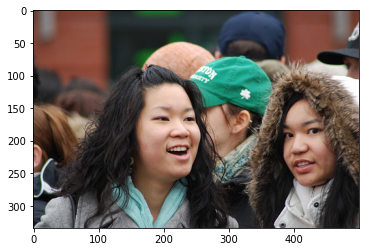

In [142]:
# pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/test/3385593926_d3e9c21170.jpg', 'r')
# pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/test/2677656448_6b7e7702af.jpg', 'r')
# pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/test/311146855_0b65fdb169.jpg', 'r')
# pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/test/1258913059_07c613f7ff.jpg', 'r')
# pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/test/241347760_d44c8d3a01.jpg', 'r')
# pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/test/2654514044_a70a6e2c21.jpg', 'r')
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/576_Project_Plan/test/2339106348_2df90aa6a9.jpg', 'r')

# pil_im = Image.open('/home/team8/bhk.jpg', 'r')
test = np.asarray(pil_im)
test = transform(pil_im)
test = test.unsqueeze(0)
test = Variable(test).cuda()
cnn_out = cnn(test)
lstm_out = lstm.greedy(cnn_out)
imshow(np.asarray(pil_im))
print("prediction: ",vocab.get_sentence(lstm_out))